## Imporatación de las librerías

In [30]:
#EDA
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  

import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#Modelos
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

#Resultados
import shap

## Lectura datos UH_2023_TRAIN

In [2]:
uh_2023_df = pd.read_csv('/kaggle/input/cajamar-malbec/UH_2023/UH_2023_TRAIN.txt', sep= '|', header=0 )
uh_2023_df.columns = [col.lower().replace('-','_') for col in uh_2023_df.columns]
uh_2023_df.head()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion
0,14,76953,515,4,660,26,2,0,1,0.00,22215.00
1,14,84318,515,4,660,26,2,0,1,0.00,22215.00
2,14,85579,340,4,520,32,2,0,1,0.00,20978.00
3,14,69671,340,4,520,32,2,0,1,0.00,40722.00
4,14,14001,852,14,NaN,81,1,0,1,0.00,14126.00


In [3]:
print(f'Número de filas: {uh_2023_df.shape[0]}, Número de columnas:{uh_2023_df.shape[1]}')
print(f'\nCantidad de duplicados: {uh_2023_df.duplicated().sum()}\n')
print('-------- Tipos de columnas --------')
print(uh_2023_df.dtypes)
print('\n -------- Cantidad de nulos --------')
uh_2023_df.isna().sum()

Número de filas: 9601, Número de columnas:11

Cantidad de duplicados: 0

-------- Tipos de columnas --------
campaña          int64
id_finca         int64
id_zona          int64
id_estacion      int64
altitud         object
variedad         int64
modo             int64
tipo             int64
color            int64
superficie     float64
produccion     float64
dtype: object

 -------- Cantidad de nulos --------


campaña           0
id_finca          0
id_zona           0
id_estacion       0
altitud          54
variedad          0
modo              0
tipo              0
color             0
superficie        0
produccion     1075
dtype: int64

## Transformaciones

**Altitud**

In [4]:
def transform_altitud(alt):
    if type(alt) is str:
        alt_list = alt.split("-")
        alt_list = list(map(float, alt_list))
        return np.mean(alt_list) 
    return alt

In [5]:
uh_2023_df['altitud'] = uh_2023_df['altitud'].apply(lambda alt: transform_altitud(alt))
uh_2023_df.describe()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion
count,9601.00,9601.00,9601.00,9601.00,9547.00,9601.00,9601.00,9601.00,9601.00,9601.00,8526.00
mean,17.94,50818.24,498.50,12.16,577.85,45.49,1.51,0.01,0.84,0.70,9209.19
std,2.61,29016.57,261.43,4.76,76.49,23.81,0.50,0.11,0.36,1.79,13268.81
min,14.00,200.00,7.00,0.00,370.00,4.00,1.00,0.00,0.00,0.00,0.72
25%,16.00,25104.00,284.00,7.00,490.00,17.00,1.00,0.00,1.00,0.00,1940.00
50%,18.00,50946.00,464.00,12.00,610.00,52.00,2.00,0.00,1.00,0.00,4620.00
75%,20.00,76361.00,726.00,16.00,635.00,59.00,2.00,0.00,1.00,0.56,11137.50
max,22.00,99793.00,990.00,19.00,820.00,94.00,2.00,1.00,1.00,26.85,177520.00


## División del dataset

Sacamos el año 2021 como conjunto de **test**.

Este presenta nulos en la altitud, se debe tener en cuenta.

In [6]:
test_2021_df = uh_2023_df[uh_2023_df['campaña'] == 21]
print(test_2021_df.shape)
test_2021_df.isna().sum()

(1044, 11)


campaña        0
id_finca       0
id_zona        0
id_estacion    0
altitud        6
variedad       0
modo           0
tipo           0
color          0
superficie     0
produccion     0
dtype: int64

In [7]:
train_df_with_2022 = uh_2023_df[uh_2023_df['campaña'] != 21]
print(train_df_with_2022.shape)
train_df_with_2022.isna().sum()

(8557, 11)


campaña           0
id_finca          0
id_zona           0
id_estacion       0
altitud          48
variedad          0
modo              0
tipo              0
color             0
superficie        0
produccion     1075
dtype: int64

## Tratamiento NA

**Variable Altitud en TRAIN**

In [8]:
train_df_with_2022[train_df_with_2022.altitud.isnull()].shape

(48, 11)

In [9]:
mean_altitudes_train = pd.DataFrame(train_df_with_2022.groupby('id_estacion')['altitud'].mean()).reset_index()
df_altitud = train_df_with_2022.merge(mean_altitudes_train, how='left', on='id_estacion')
df_altitud['altitud'] = df_altitud.altitud_x.fillna(df_altitud.altitud_y)
df_altitud.drop(columns=['altitud_x','altitud_y'], inplace=True)
train_df_with_2022 = df_altitud.copy()
train_df_with_2022[train_df_with_2022.altitud.isnull()].shape

(0, 11)

**Variable altitud en TEST**

In [10]:
mean_altitudes_test = pd.DataFrame(test_2021_df.groupby('id_estacion')['altitud'].mean()).reset_index()
df_altitud = test_2021_df.merge(mean_altitudes_test, how='left', on='id_estacion')
df_altitud['altitud'] = df_altitud.altitud_x.fillna(df_altitud.altitud_y)
df_altitud.drop(columns=['altitud_x','altitud_y'], inplace=True)
test_2021_df = df_altitud.copy()
test_2021_df[test_2021_df.altitud.isnull()].shape

(0, 11)

**Variable superficie en TRAIN**

Hay superficies que están a 0 y que deben de ser imputadas

In [11]:
train_df_with_2022['superficie'] = train_df_with_2022['superficie'].replace(0, np.nan)
train_df_with_2022[train_df_with_2022['superficie'].isnull()].shape

(6498, 11)

Vamos cubriendo los NAs segun por menor a mayor jerarquia

In [12]:
train_df_with_2022['superficie'] = train_df_with_2022.groupby(['id_finca','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
train_df_with_2022['superficie'] = train_df_with_2022.groupby(['id_zona','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
train_df_with_2022['superficie'] = train_df_with_2022.groupby(['id_estacion','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
train_df_with_2022['superficie'] = train_df_with_2022.groupby(['variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
train_df_with_2022['superficie'] = train_df_with_2022.groupby(['variedad'])['superficie'].transform(lambda x: x.fillna(x.mean()))
train_df_with_2022.superficie.isna().sum()

0

**Variable superficie en TEST**

In [13]:
test_2021_df['superficie'] = test_2021_df['superficie'].replace(0, np.nan)
test_2021_df[test_2021_df['superficie'].isnull()].shape

(20, 11)

In [14]:
test_2021_df['superficie'] = test_2021_df.groupby(['id_finca','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
test_2021_df['superficie'] = test_2021_df.groupby(['id_zona','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
test_2021_df.superficie.isna().sum()

0

## Mutual Information with production

Quitamos el 2022 ya que no tiene datos de producción y probamos mutual information

In [15]:
train_df_without_2022 = train_df_with_2022[train_df_with_2022['campaña'] != 22]
print(train_df_without_2022.shape)
train_df_without_2022.isna().sum()

(7482, 11)


campaña        0
id_finca       0
id_zona        0
id_estacion    0
variedad       0
modo           0
tipo           0
color          0
superficie     0
produccion     0
altitud        0
dtype: int64

In [16]:
categorical_vars, continous_vars, target = list(train_df_without_2022.columns)[:-3], ['superficie', 'altitud'], ['produccion'] 
print(categorical_vars, continous_vars, target)
train_df_without_2022_copy = train_df_without_2022.copy()
test_2021_df_copy = test_2021_df.copy()

['campaña', 'id_finca', 'id_zona', 'id_estacion', 'variedad', 'modo', 'tipo', 'color'] ['superficie', 'altitud'] ['produccion']


In [17]:
label_encoder = LabelEncoder()
for categorical_var in categorical_vars:
    train_df_without_2022_copy[categorical_var] = label_encoder.fit_transform(train_df_without_2022_copy[categorical_var])
    test_2021_df_copy[categorical_var] = label_encoder.fit_transform(test_2021_df_copy[categorical_var])

In [18]:
test_2021_df_copy.head()

,campaña,id_finca,id_zona,id_estacion,variedad,modo,tipo,color,superficie,produccion,altitud
0,0,374,31,10,8,1,0,1,3.75,26549.05,600.00
1,0,366,31,10,8,1,0,1,7.37,52630.95,600.00
2,0,234,57,11,5,1,0,1,2.66,771.88,662.02
3,0,49,92,11,15,0,0,1,7.62,7800.00,655.00
4,0,367,92,11,15,1,0,1,1.12,4344.91,655.00


Calculamos el mutual information para cada variable con respecto a la target continua.

In [19]:
discrete_vars = [True, True, True, True, True, True, True, True, False, False]
mutual_info = mutual_info_regression(train_df_without_2022_copy.drop(columns=['produccion']),
                                     train_df_without_2022_copy.produccion, discrete_features=discrete_vars)

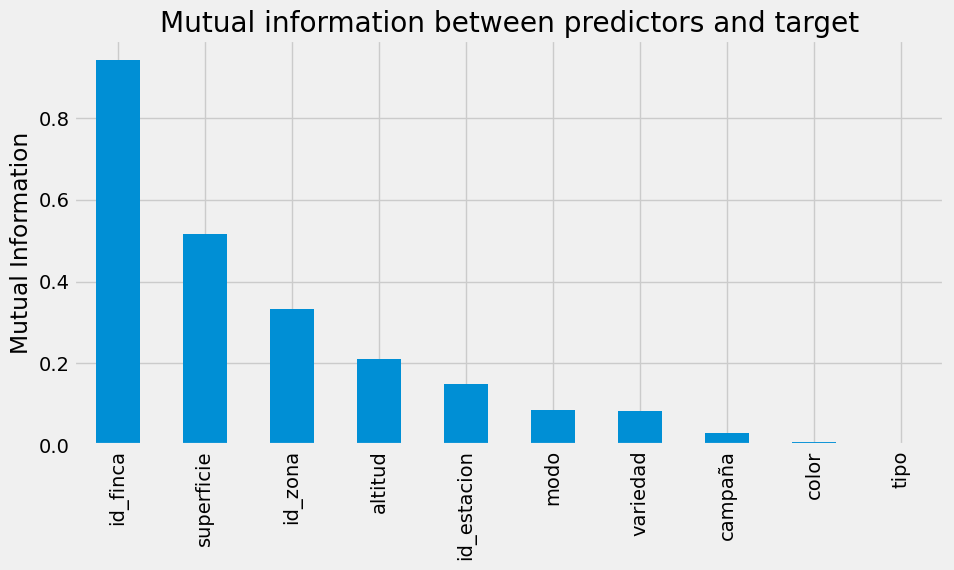

In [20]:
mutual_info_df = pd.Series(mutual_info)
mutual_info_df.index = train_df_without_2022_copy.drop(columns=['produccion']).columns
mutual_info_df.sort_values(ascending=False).plot.bar(figsize=(10, 5))
plt.ylabel('Mutual Information')
plt.title("Mutual information between predictors and target")
plt.show()

## Búsqueda de modelos solo con variables de mutual info

Funciones comunes

In [33]:
seed = 99

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def train_evaluate_model(model, X, y, train_test_idx):
    res = {
        "rmse":[],
        "mape":[],
    }
    for idxs in train_test_idx:
        model_ = clone(model)
        train_idx, test_idx = idxs[0], idxs[1]
        X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        model_.fit(X_train, y_train)
        print("PREDICT")
        y_pred = model_.predict(X_test)
        mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
        rmse = rmse_score(y_true=y_test, y_pred=y_pred)
        res['mape'].append(mape)
        res['rmse'].append(rmse)
    return res

In [22]:
data = pd.concat([train_df_without_2022, test_2021_df])
X = data.drop(columns="produccion")
y = data['produccion']
train_idx, test_idx =  X['campaña']!=21, X['campaña']==21
train_idx2, test_idx2 =  X['campaña']!=20, X['campaña']==20
train_idx3, test_idx3 =  X['campaña']!=19, X['campaña']==19
train_test_idx = [(train_idx, test_idx),(train_idx2, test_idx2), (train_idx3, test_idx3)]
print(X.shape, y.shape)

(8526, 10) (8526,)


In [23]:
mutual_cat_cols, mutual_cont_cols = ['id_finca', 'id_zona', 'id_estacion', 'variedad', 'modo'], ['superficie', 'altitud']
print(mutual_cat_cols, mutual_cont_cols)

['id_finca', 'id_zona', 'id_estacion', 'variedad', 'modo'] ['superficie', 'altitud']


### RandomForestRegressor

In [24]:
col_transformer = ColumnTransformer([
    ("oridinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), mutual_cat_cols),
    ("min_max_scaler", MinMaxScaler(), mutual_cont_cols)
],remainder='passthrough')

pipeline = Pipeline([
    ('col_transformer', col_transformer),
    ('rfr', RandomForestRegressor(random_state=seed))
])

train_evaluate_model(model=pipeline,
                     X=X[mutual_cat_cols + mutual_cont_cols],
                     y=y,
                     train_test_idx=train_test_idx)

{'rmse': [6196.669208934582, 7021.494696307207, 4956.890657048953],
 'mape': [6.034161559759343, 1.018395895154008, 0.6413463133434091]}

### CatboostRegressor

In [25]:
train_evaluate_model(
    CatBoostRegressor(random_state=seed, cat_features=mutual_cat_cols, verbose=0),
    X=X[mutual_cat_cols + mutual_cont_cols],
    y=y,
    train_test_idx=train_test_idx
)

{'rmse': [6637.106962304919, 7791.4966728125155, 5154.068760502561],
 'mape': [6.285605835323124, 1.3885564201114788, 1.0737353129474023]}

### XGBRegressor

In [26]:
col_transformer = ColumnTransformer([
    ("oridinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), mutual_cat_cols),
    ("min_max_scaler", MinMaxScaler(), mutual_cont_cols)
],remainder='passthrough')

pipeline = Pipeline([
    ('col_transformer', col_transformer),
    ('rxgb', XGBRegressor(random_state=seed))
])

train_evaluate_model(model=pipeline,
                     X=X[mutual_cat_cols + mutual_cont_cols],
                     y=y,
                     train_test_idx=train_test_idx)

{'rmse': [6016.6497502849625, 6986.053811460566, 4834.671575078042],
 'mape': [6.569408946382969, 1.1776051323300782, 0.8875340167082687]}

### SVM

In [28]:
col_transformer = ColumnTransformer([
    ("oridinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), mutual_cat_cols),
    ("min_max_scaler", MinMaxScaler(), mutual_cont_cols)
],remainder='passthrough')

pipeline = Pipeline([
    ('col_transformer', col_transformer),
    ('svm', SVR())
])

train_evaluate_model(model=pipeline,
                     X=X[mutual_cat_cols + mutual_cont_cols],
                     y=y,
                     train_test_idx=train_test_idx)

{'rmse': [14670.046849695946, 14322.521684057148, 12651.919417604613],
 'mape': [13.830319812393824, 6.788483447586647, 4.736832650490495]}

### STACKING

In [36]:
estimators = [
    ('rfr', RandomForestRegressor(random_state=seed)),
    ('rxgb', XGBRegressor(random_state=seed)),
    ('cat_boost', CatBoostRegressor(random_state=seed, cat_features=mutual_cat_cols))
]

stacking_models = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(random_state=seed),
    n_jobs=-1
)

train_evaluate_model(model=stacking_models,
                     X=X[mutual_cat_cols + mutual_cont_cols],
                     y=y,
                     train_test_idx=train_test_idx)

Learning rate set to 0.05627
0:	learn: 12809.4975178	total: 58.6ms	remaining: 58.5s
1:	learn: 12444.9012697	total: 66.6ms	remaining: 33.2s
2:	learn: 12134.8764263	total: 75ms	remaining: 24.9s
3:	learn: 11822.2180437	total: 84.3ms	remaining: 21s
4:	learn: 11532.1904492	total: 92.4ms	remaining: 18.4s
5:	learn: 11261.6722812	total: 99.4ms	remaining: 16.5s
6:	learn: 11029.4952077	total: 110ms	remaining: 15.6s
7:	learn: 10794.2619142	total: 120ms	remaining: 14.8s
8:	learn: 10572.2555726	total: 127ms	remaining: 14s
9:	learn: 10393.1894731	total: 135ms	remaining: 13.4s
10:	learn: 10216.1478724	total: 144ms	remaining: 12.9s
11:	learn: 10045.5715320	total: 151ms	remaining: 12.4s
12:	learn: 9870.9828552	total: 161ms	remaining: 12.2s
13:	learn: 9720.2290180	total: 169ms	remaining: 11.9s
14:	learn: 9572.6278608	total: 180ms	remaining: 11.8s
15:	learn: 9434.6179936	total: 187ms	remaining: 11.5s
16:	learn: 9320.0001000	total: 197ms	remaining: 11.4s
17:	learn: 9201.7173779	total: 207ms	remaining: 11.

{'rmse': [7247.55370647371, 7501.88760365227, 5388.437836474038],
 'mape': [6.256062193793912, 1.1490498868374992, 0.7536929638215262]}